In [25]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import matplotlib

In [128]:

intrinsics = b.Intrinsics(
    height=300,
    width=300,
    fx=500.0, fy=500.0,
    cx=150.0, cy=150.0,
    near=0.01, far=10.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [14]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [144]:
IDX = 11
pc = jnp.array(b.RENDERER.meshes[IDX].vertices)
pc_subsampled = pc[jax.random.choice(jax.random.PRNGKey(10), jnp.arange(pc.shape[0]), shape=(10000,) )]
b.show_cloud("1",pc)

In [ ]:
poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle) for angle in jnp.linspace(0.0, 4*jnp.pi, 200)])

In [137]:
def render_point_light(pose, pc_subsampled):
    point_cloud_img = b.RENDERER.render_single_object(pose,  jnp.int32(IDX))[:,:,:3]
    point_cloud_img_in_object_frame = b.t3d.apply_transform(point_cloud_img, b.t3d.inverse_pose(pose))

    distances_to_keypoints = (
        jnp.linalg.norm(point_cloud_img_in_object_frame[:, :,None,...] - pc_subsampled[None, None,:,...],
        axis=-1
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints.min(2)

    DISTANCE_THRESHOLD = 0.0005
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
    return valid_match_mask
render_point_light_parallel_jit = jax.jit(jax.vmap(render_point_light, in_axes=(0, None)))


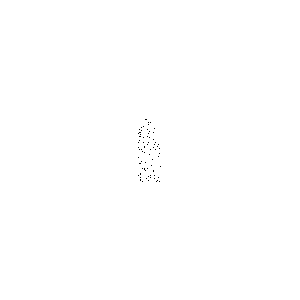

In [138]:
images = render_point_light_parallel_jit(poses, pc_subsampled)
b.get_depth_image(images[0,...,2] * 1.0, cmap=matplotlib.colormaps['Greys'])

In [139]:
flips = (jax.random.uniform(jax.random.PRNGKey(10),shape=images.shape) < 0.0)
noisy_data = (images * jnp.logical_not(flips)) + (jnp.logical_not(images) * flips)


In [140]:
viz = [b.get_depth_image(point_light_image * 1.0, cmap=matplotlib.colormaps['Greys']) for point_light_image in noisy_data ]
b.make_gif_from_pil_images(viz, "out.gif")

In [61]:
images

Array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [60]:
jnp.logical_not(images)

Array([[[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        ...,

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]]],


       [[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ T